# Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Download candles

In [3]:
# Inicializa a conexão com o MetaTrader 5
if not mt5.initialize():
    print("Falha ao inicializar o MT5")
    mt5.shutdown()

# Escolha o símbolo e o período de tempo para coletar dados
symbol = "BTCUSDT"
timeframe = mt5.TIMEFRAME_M15  # Gráfico de 1 hora
bars = mt5.copy_rates_from_pos(symbol, timeframe, 0, 10000)  # Últimos 1000 candles

# Converte os dados em um DataFrame do pandas
data = pd.DataFrame(bars)
data['time'] = pd.to_datetime(data['time'], unit='s')

# Finaliza a conexão com o MT5
mt5.shutdown()


True

In [4]:
display(data)

,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-06-10 19:00:00,70044.9,70100.0,69851.0,69882.2,128905,0,1405
1,2024-06-10 19:15:00,69882.2,70004.4,69715.8,69812.4,93355,0,1192
2,2024-06-10 19:30:00,69812.4,70025.0,69728.0,69982.0,70515,0,593
3,2024-06-10 19:45:00,69982.0,70030.0,69952.6,69970.0,64335,0,644
4,2024-06-10 20:00:00,69970.0,69974.6,69750.4,69877.5,83785,0,687
...,...,...,...,...,...,...,...,...
9995,2024-09-23 01:45:00,63481.8,63996.0,63481.8,63853.5,1627,0,0
9996,2024-09-23 02:00:00,63853.5,63949.2,63551.0,63575.9,1214,0,0
9997,2024-09-23 02:15:00,63575.9,63632.0,63387.3,63468.8,722,0,0
9998,2024-09-23 02:30:00,63468.8,63599.9,63393.6,63541.0,471,0,0


# Funcs

In [8]:
# Função para calcular o CCI
def CCI(df, n):
    tp = (df['high'] + df['low'] + df['close']) / 3  # Preço típico
    sma = tp.rolling(n).mean()  # Média móvel simples
    mad = lambda x: np.mean(np.abs(x - np.mean(x)))  # Calculando o MAD manualmente
    rolling_mad = tp.rolling(n).apply(mad, raw=True)  # Aplicando o MAD manual
    cci = (tp - sma) / (0.015 * rolling_mad)  # Fórmula do CCI
    return cci

# Função para calcular RSI
def RSI(df, n):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(n).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(n).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
  
def BollingerBands(df, n=20, k=2):
    sma = df['close'].rolling(n).mean()
    std = df['close'].rolling(n).std()
    upper_band = sma + (k * std)
    lower_band = sma - (k * std)
    return upper_band, lower_band

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    df['fast_ema'] = df['close'].ewm(span=fast_period, adjust=False).mean()
    df['slow_ema'] = df['close'].ewm(span=slow_period, adjust=False).mean()
    df['macd'] = df['fast_ema'] - df['slow_ema']
    df['macd_signal'] = df['macd'].ewm(span=signal_period, adjust=False).mean()
    return df

def calculate_atr(df, period=14):
    df['high-low'] = df['high'] - df['low']
    df['high-close'] = abs(df['high'] - df['close'].shift())
    df['low-close'] = abs(df['low'] - df['close'].shift())
    df['true_range'] = df[['high-low', 'high-close', 'low-close']].max(axis=1)
    df['atr'] = df['true_range'].rolling(window=period).mean()
    return df

# Organizing data

In [10]:
data['Momentum'] = data['close'].pct_change(5)  # Retorno percentual nos últimos 5 períodos
data['Upper_BB'], data['Lower_BB'] = BollingerBands(data, 20)
data['SMA'] = data['close'].rolling(20).mean()  # Média móvel simples de 20 períodos
data['RSI'] = RSI(data, 14)  # RSI com janela de 14 períodos
data['CCI'] = CCI(data, 20)  # CCI com janela de 20 períodos
# data['label'] = (data['close'].shift(-1) > data['close']).astype(int)  # Label baseado na variação de preço
data['Avg_Volume'] = data['tick_volume'].rolling(20).mean()

# Remover NaN criados pela função shift e CCI
data.dropna(inplace=True)


# Definir threshold para variação percentual futura
threshold = 0.0002  # Ajuste esse valor conforme necessário (0.5% de variação)

# Criar a label com base na variação percentual futura
data['future_price'] = data['close'].shift(-1)
data['price_change'] = (data['future_price'] - data['close']) / data['close']

# Se a variação for maior que o threshold, o label será 1 (compra), caso contrário, será 0 (venda)
data['label'] = (data['price_change'] > threshold).astype(int)

# Remover NaN criados pela função shift e indicadores
data.dropna(inplace=True)



X = data[['Avg_Volume','Momentum','Upper_BB','Lower_BB','RSI', 'SMA', 'CCI', 'open', 'high', 'low', 'close', 'tick_volume']]  # Features
y = data['label']  # Labels

In [11]:
data.label.value_counts()

label
0    5354
1    4606
Name: count, dtype: int64

# Randon Forest

In [15]:
data = calculate_macd(data)
data = calculate_atr(data)

# Features atualizadas
X = data[['Avg_Volume', 'Momentum', 'Upper_BB', 'Lower_BB', 'RSI', 'SMA', 'CCI', 'open', 'high', 'low', 'close', 'tick_volume', 'macd', 'macd_signal', 'atr']]
y = data['label']

X.dropna(inplace=True)
y.dropna(inplace=True)
# Validação cruzada usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Parâmetros para a busca
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# GridSearchCV para otimizar os hiperparâmetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

# Aplicar SMOTE apenas no conjunto de treino e rodar a busca
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Aplicar o SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Ajustar o modelo com GridSearch
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    # Melhor conjunto de hiperparâmetros
    best_params = grid_search.best_params_
    print(f"Melhores hiperparâmetros: {best_params}")
    
    # Avaliar o melhor modelo no conjunto de teste
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia na divisão atual: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

# Mostrar o melhor conjunto de parâmetros após toda a busca
print(f"Melhor conjunto de parâmetros após GridSearchCV: {grid_search.best_params_}")


C:\Users\Ikaro\AppData\Local\Temp\ipykernel_25244\2656728677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Melhores hiperparâmetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Acurácia na divisão atual: 0.56
              precision    recall  f1-score   support

           0       0.58      0.68      0.62       887
           1       0.53      0.42      0.47       770

    accuracy                           0.56      1657
   macro avg       0.55      0.55      0.55      1657
weighted avg       0.56      0.56      0.55      1657

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Melhores hiperparâmetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
Acurácia na divisão atual: 0.58
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       880
           1       0.55      0.66      0.60       777

    accuracy                           0.58    

In [16]:
# Aplicar os indicadores técnicos
data = calculate_macd(data)
data = calculate_atr(data)

# Features atualizadas com MACD e ATR
X = data[['Avg_Volume', 'Momentum', 'Upper_BB', 'Lower_BB', 'RSI', 'SMA', 'CCI', 'open', 'high', 'low', 'close', 'tick_volume', 'macd', 'macd_signal', 'atr']]
y = data['label']

X.dropna(inplace=True)
y.dropna(inplace=True)

# Validação cruzada usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Aplicar o melhor conjunto de parâmetros diretamente ao modelo

# best_params = {
#     'max_depth': 15,
#     'max_features': 'sqrt',
#     'min_samples_leaf': 4,
#     'min_samples_split': 2,
#     'n_estimators': 100
# }

best_params = grid_search.best_params_

# RandomForestClassifier com os melhores hiperparâmetros
model = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

# Avaliar o modelo usando TimeSeriesSplit e SMOTE
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Aplicar SMOTE para balancear o conjunto de treino
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Ajustar o modelo com os dados balanceados
    model.fit(X_train_resampled, y_train_resampled)
    
    # Fazer a previsão no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Avaliar o modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia na divisão atual: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))



C:\Users\Ikaro\AppData\Local\Temp\ipykernel_25244\1624205719.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


Acurácia na divisão atual: 0.57
              precision    recall  f1-score   support

           0       0.59      0.69      0.63       887
           1       0.55      0.44      0.49       770

    accuracy                           0.57      1657
   macro avg       0.57      0.56      0.56      1657
weighted avg       0.57      0.57      0.57      1657

Acurácia na divisão atual: 0.58
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       880
           1       0.55      0.66      0.60       777

    accuracy                           0.58      1657
   macro avg       0.59      0.59      0.58      1657
weighted avg       0.59      0.58      0.58      1657

Acurácia na divisão atual: 0.56
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       879
           1       0.55      0.36      0.44       778

    accuracy                           0.56      1657
   macro avg       0.56      0.5

Acurácia do modelo: 0.61
[[644 231]
 [413 369]]
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       875
           1       0.61      0.47      0.53       782

    accuracy                           0.61      1657
   macro avg       0.61      0.60      0.60      1657
weighted avg       0.61      0.61      0.60      1657

AUC-ROC: 0.64


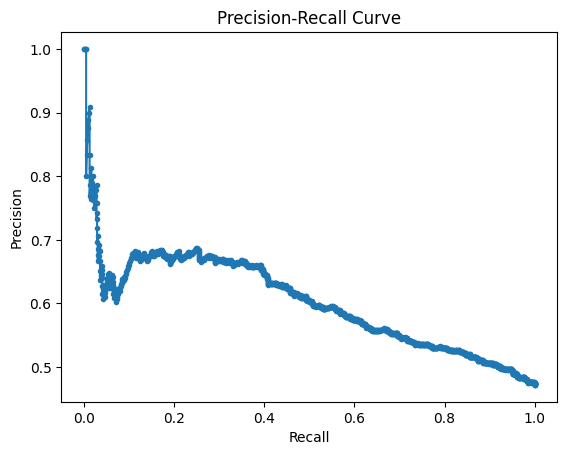

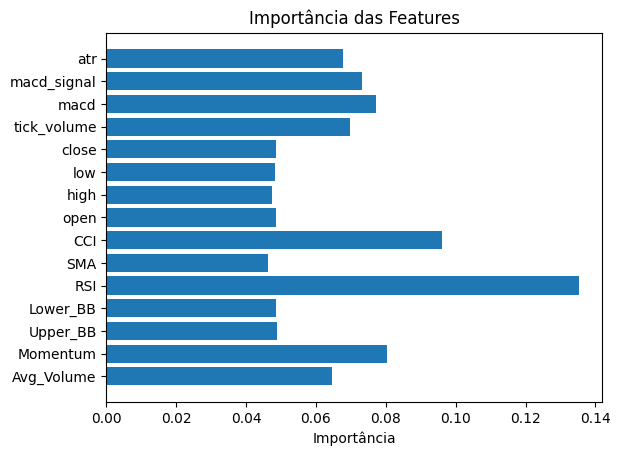

In [20]:
# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")

# Mostrar métricas adicionais
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calcular AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc:.2f}")

# Calcular precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plotar a curva precision-recall
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Importância das features
importances = model.feature_importances_
feature_names = X.columns

# Plotar a importância das features
plt.barh(feature_names, importances)
plt.xlabel('Importância')
plt.title('Importância das Features')
plt.show()


In [21]:
import pickle

# Salvar o modelo treinado
with open('modelo_rf.pkl', 'wb') as file:
    pickle.dump(model, file)
